In [26]:
import pandas as pd
import numpy as np

# Load Dataset
file_path = "nhs_ae_merged_fixed.csv"
nhs_data = pd.read_csv(file_path)

# Convert 'year' to string and 'month' to categorical
nhs_data["year"] = nhs_data["year"].astype(str)
nhs_data["month"] = pd.Categorical(nhs_data["month"], categories=[
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
], ordered=True)

# Handle missing months
if nhs_data["month"].isna().sum() > 0:
    nhs_data.loc[nhs_data["month"].isna(), "month"] = nhs_data["period"].str.extract(r'-(\w+)-')[0]

# Drop rows where 'month' is still missing
nhs_data.dropna(subset=["month"], inplace=True)

# 🔍 Fix Inf and NaN Values in 'total_a&e_attendances'
nhs_data["total_a&e_attendances"].replace([np.inf, -np.inf], np.nan, inplace=True)
nhs_data["total_a&e_attendances"].fillna(nhs_data["total_a&e_attendances"].median(), inplace=True)

# 🔍 Fill Missing Attendance Columns Using Yearly Averages, then Median
attendance_columns = [
    "number_of_a&e_attendances_type_1",
    "number_of_a&e_attendances_type_2",
    "number_of_a&e_attendances_other_a&e_department",
    "number_of_attendances_over_4hrs_type_1",
    "number_of_attendances_over_4hrs_type_2",
    "number_of_attendances_over_4hrs_other_a&e_department"
]

for col in attendance_columns:
    if col in nhs_data.columns:
        nhs_data[col] = nhs_data.groupby("year")[col].transform("mean")
        nhs_data[col] = nhs_data[col].fillna(nhs_data[col].median())  # Final fallback

# 🔍 Check for Abnormal Attendance Data (All Same Values)
for col in attendance_columns:
    if nhs_data[col].nunique() == 1:  # If all values are identical
        print(f"⚠ Warning: {col} might have been filled incorrectly. Check imputation logic.")

# Drop Unnecessary Columns
columns_to_drop = ["a&e_attendances_type_1", "a&e_attendances_type_2", "a&e_attendances_other_a&e_department"]
nhs_data.drop(columns=[col for col in columns_to_drop if col in nhs_data.columns], inplace=True)

# 🔍 Drop Any Remaining Rows with Too Many Missing Values
nhs_data.dropna(inplace=True)

# Print Only Essential Information
print("\n✅ Data Cleaning Completed.")
print("🔍 Remaining Missing Values:\n", nhs_data.isna().sum()[nhs_data.isna().sum() > 0])

# Save Cleaned Data
cleaned_file = "nhs_ae_cleaned.csv"
nhs_data.to_csv(cleaned_file, index=False)
print(f"\n📁 Cleaned dataset saved as {cleaned_file}")


⚠ Warning: number_of_a&e_attendances_type_1 might have been filled incorrectly. Check imputation logic.
⚠ Warning: number_of_a&e_attendances_type_2 might have been filled incorrectly. Check imputation logic.
⚠ Warning: number_of_a&e_attendances_other_a&e_department might have been filled incorrectly. Check imputation logic.
⚠ Warning: number_of_attendances_over_4hrs_type_1 might have been filled incorrectly. Check imputation logic.
⚠ Warning: number_of_attendances_over_4hrs_type_2 might have been filled incorrectly. Check imputation logic.
⚠ Warning: number_of_attendances_over_4hrs_other_a&e_department might have been filled incorrectly. Check imputation logic.

✅ Data Cleaning Completed.
🔍 Remaining Missing Values:
 Series([], dtype: int64)

📁 Cleaned dataset saved as nhs_ae_cleaned.csv


/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_37448/2269316631.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nhs_data["total_a&e_attendances"].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_37448/2269316631.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object

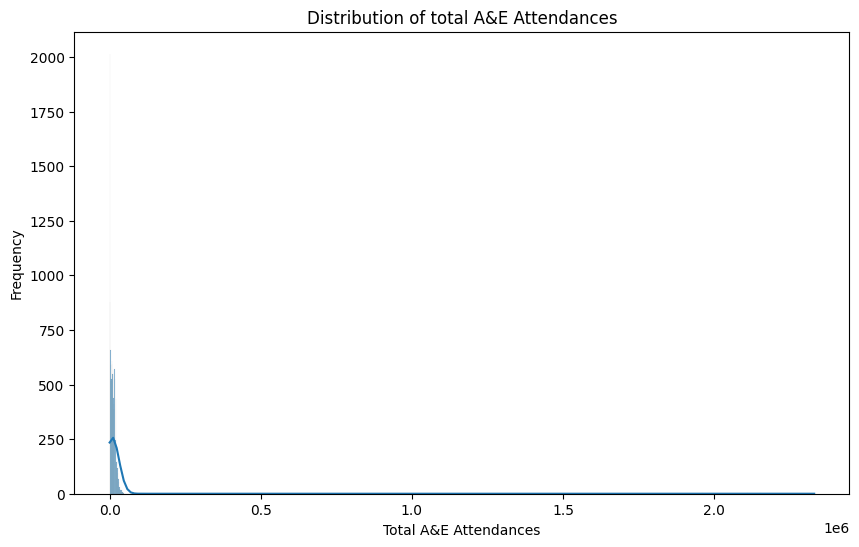

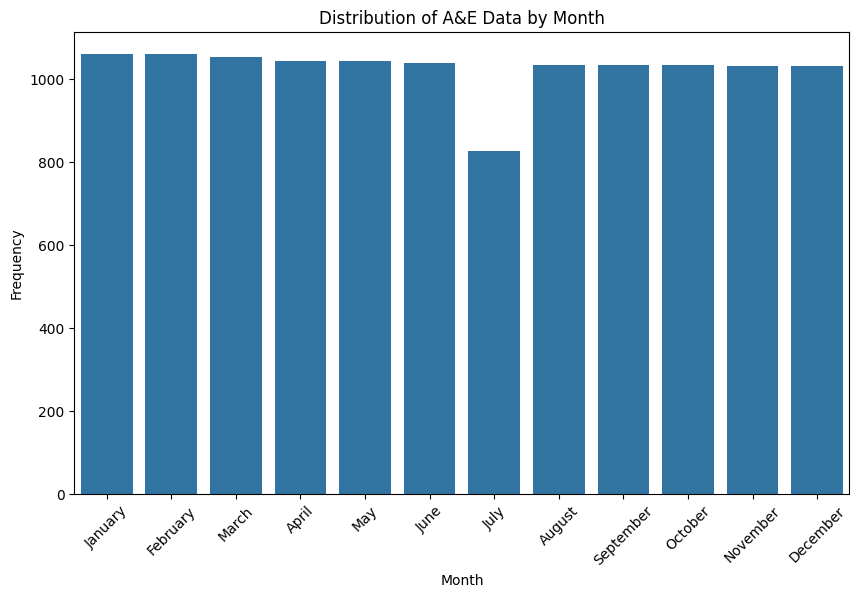

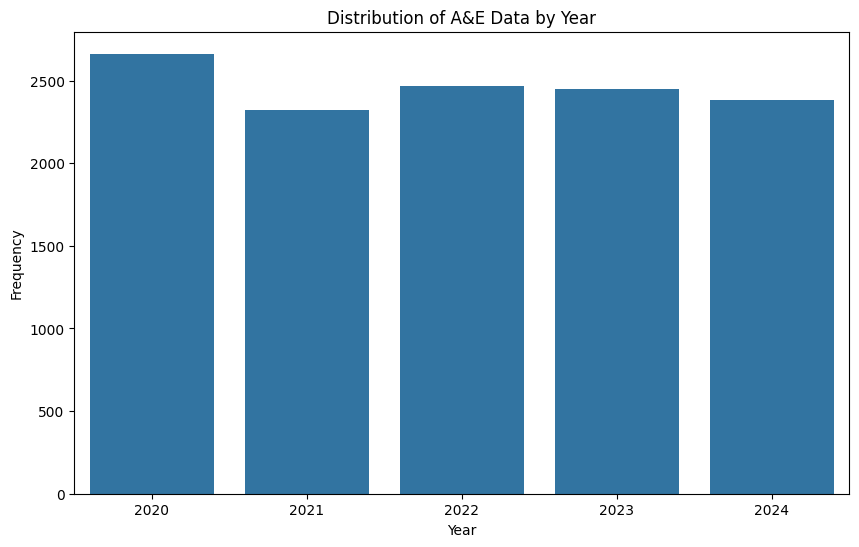

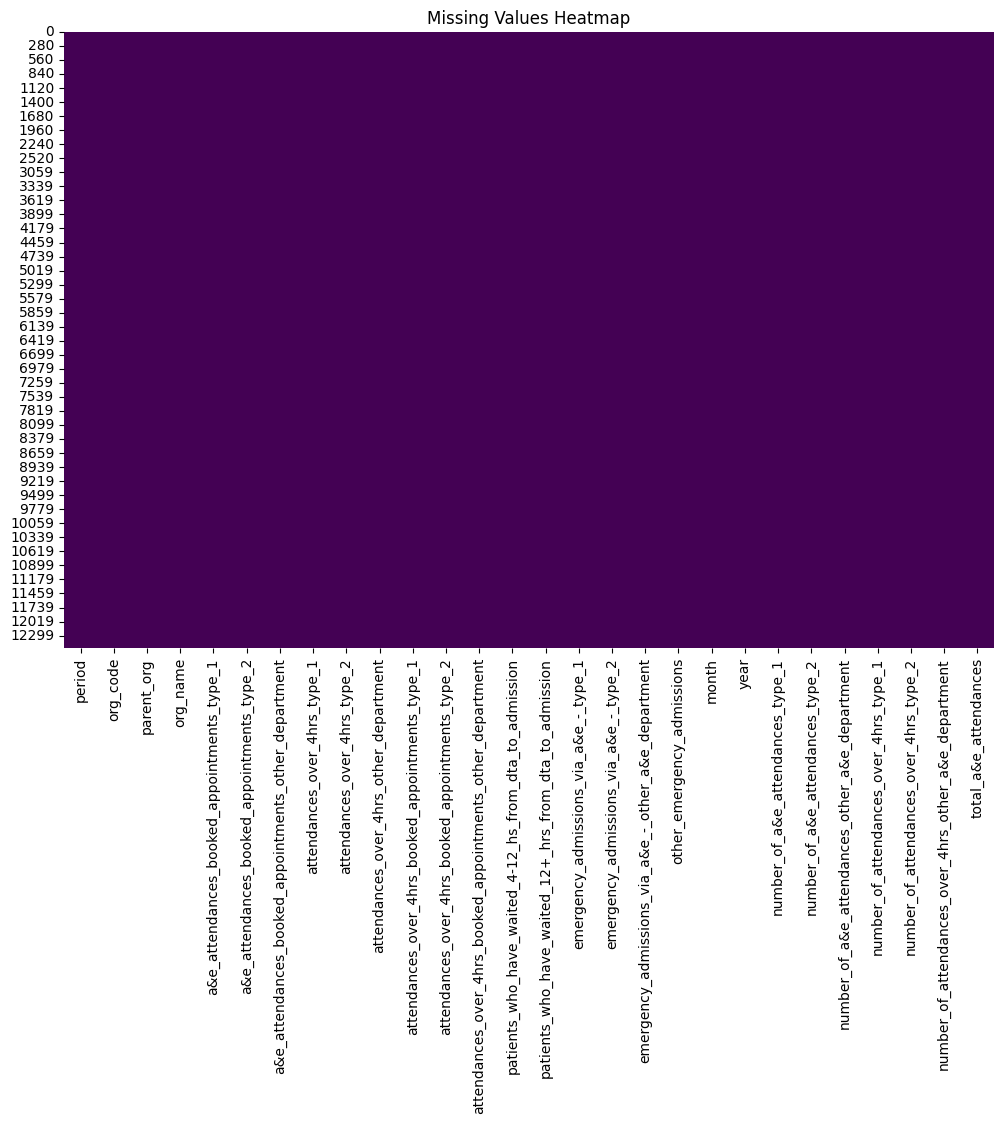

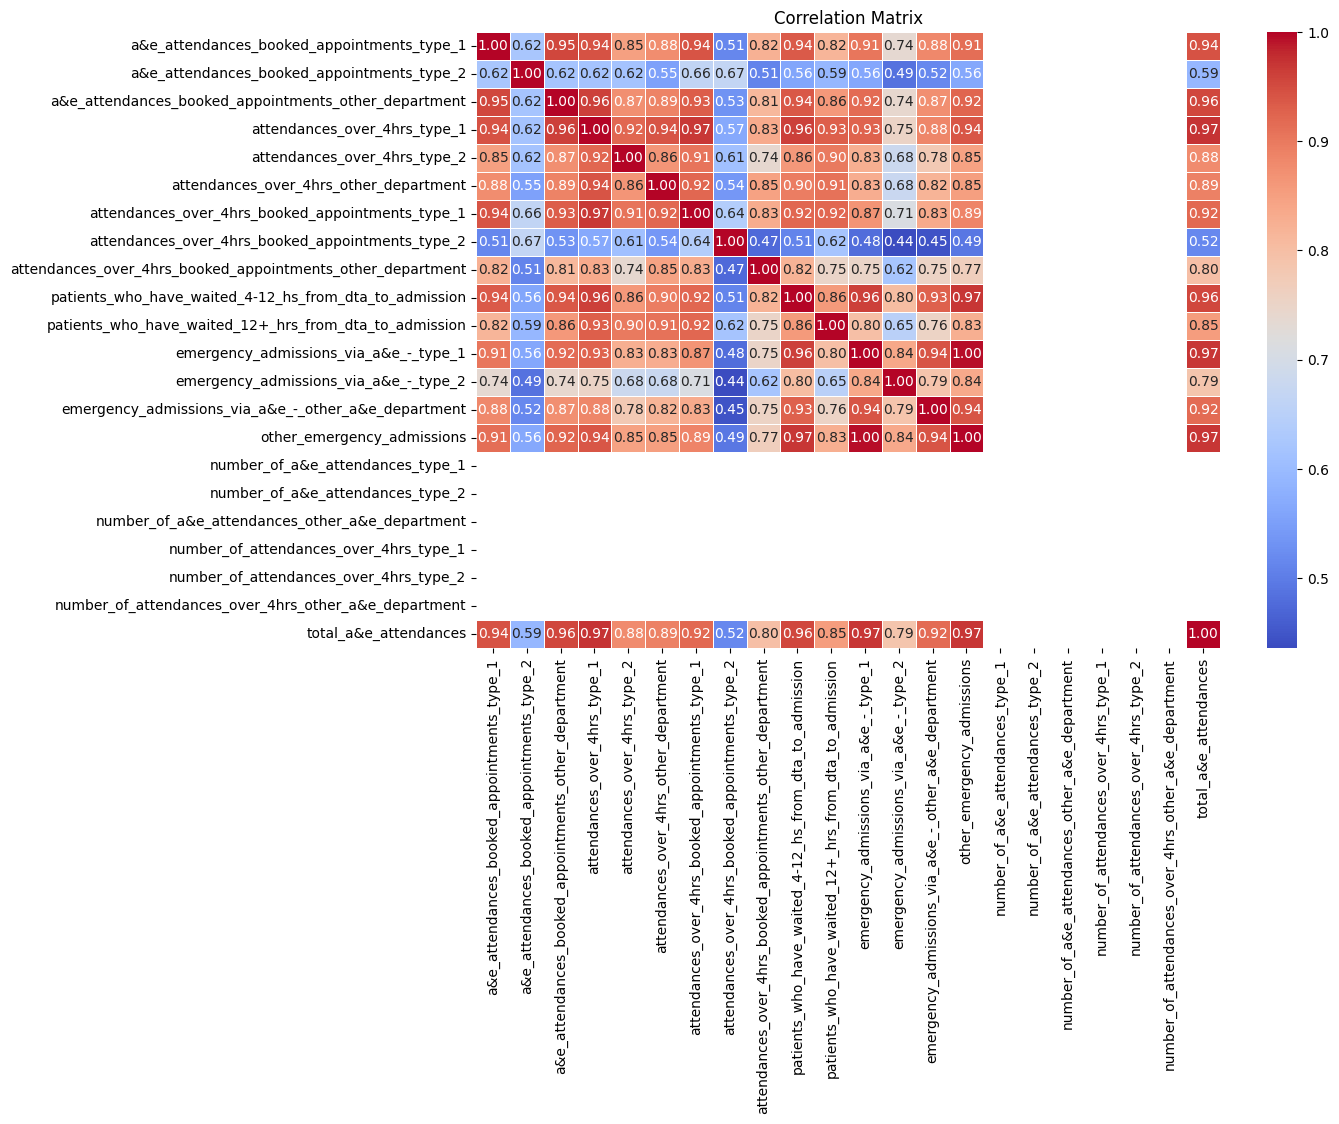

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for 'total_a&e_attendances'
plt.figure(figsize=(10, 6))
sns.histplot(nhs_data['total_a&e_attendances'], kde=True)
plt.title("Distribution of total A&E Attendances")
plt.xlabel("Total A&E Attendances")
plt.ylabel("Frequency")
plt.show()

# Bar plot for 'month' to check distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=nhs_data, x='month', order=nhs_data['month'].cat.categories)
plt.title("Distribution of A&E Data by Month")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# Bar plot for 'year' to check distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=nhs_data, x='year')
plt.title("Distribution of A&E Data by Year")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.show()

# Heatmap to visualize missing values
plt.figure(figsize=(12, 8))
sns.heatmap(nhs_data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

# Correlation Matrix (if there are many numeric features)
# Filter out non-numeric columns
numeric_data = nhs_data.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
corr = numeric_data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


### Exploratory Data Analysis (EDA): Statistical Summary & Data Distribution
#### **Why?**
Before training machine learning models, it's crucial to **understand the dataset's structure**. We:
- **Generated summary statistics** (mean, median, min, max, standard deviation).
- **Checked skewness & kurtosis** to understand data distribution.
- **Plotted boxplots** to detect **outliers** in numerical features.

#### **Key Insights:**
- **Skewness > 1 or < -1** → Indicates highly skewed distributions.
- **High kurtosis (>3)** → Indicates heavy-tailed distributions, meaning more extreme values (outliers).
- Boxplots reveal **which features contain extreme values**, guiding feature transformation strategies.


🔍 Summary Statistics:
        a&e_attendances_booked_appointments_type_1  \
count                                12286.000000   
mean                                   237.504151   
min                                      0.000000   
25%                                      0.000000   
50%                                      0.000000   
75%                                     82.000000   
max                                  43067.000000   
std                                   1915.774315   

       a&e_attendances_booked_appointments_type_2  \
count                                12286.000000   
mean                                     3.280645   
min                                      0.000000   
25%                                      0.000000   
50%                                      0.000000   
75%                                      0.000000   
max                                   1828.000000   
std                                     43.981160   

       a&e_attendance

/Users/sophieboyle/Documents/Final-Year-Project/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


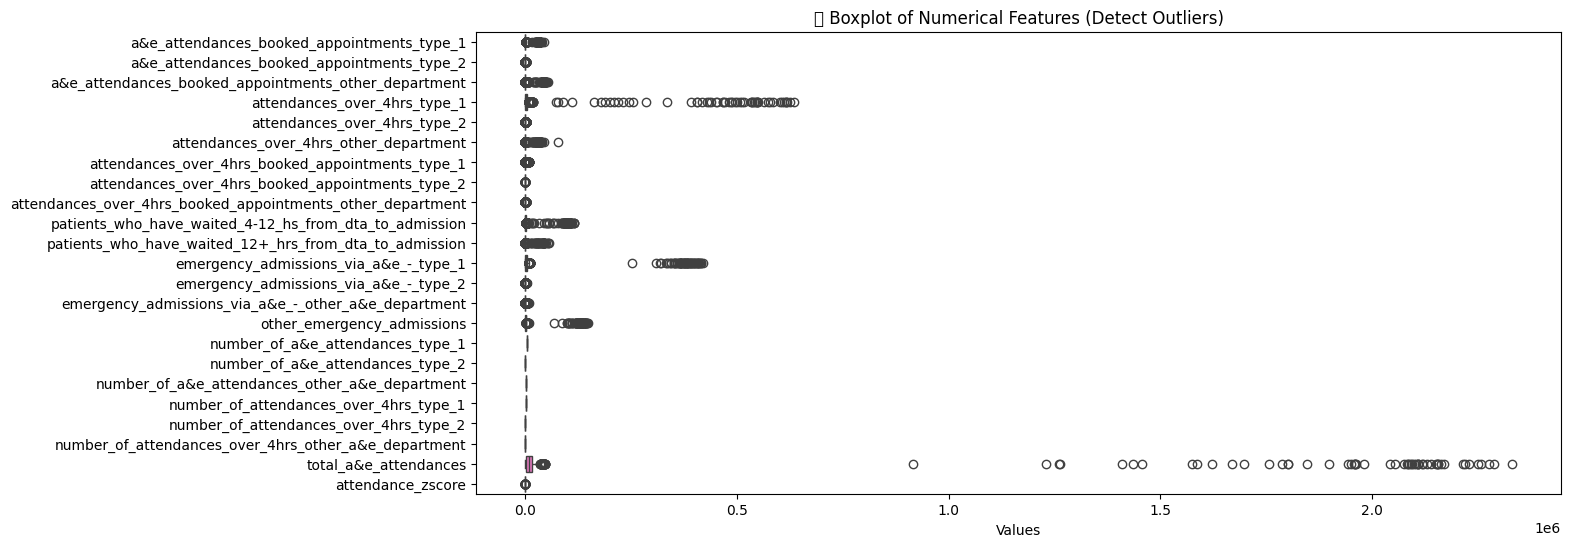

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# Display summary statistics
summary_stats = nhs_data.describe()
print("🔍 Summary Statistics:\n", summary_stats)

# Check skewness and kurtosis
skewness = nhs_data.skew(numeric_only=True)
kurt = nhs_data.kurtosis(numeric_only=True)

# Combine into DataFrame
distribution_metrics = pd.DataFrame({"Skewness": skewness, "Kurtosis": kurt})
print("\n🔍 Skewness & Kurtosis:\n", distribution_metrics)

# Visualize distributions with boxplots
plt.figure(figsize=(14, 6))
sns.boxplot(data=nhs_data.select_dtypes(include=[np.number]), orient="h")
plt.title("📊 Boxplot of Numerical Features (Detect Outliers)")
plt.xlabel("Values")
plt.show()


/Users/sophieboyle/Documents/Final-Year-Project/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


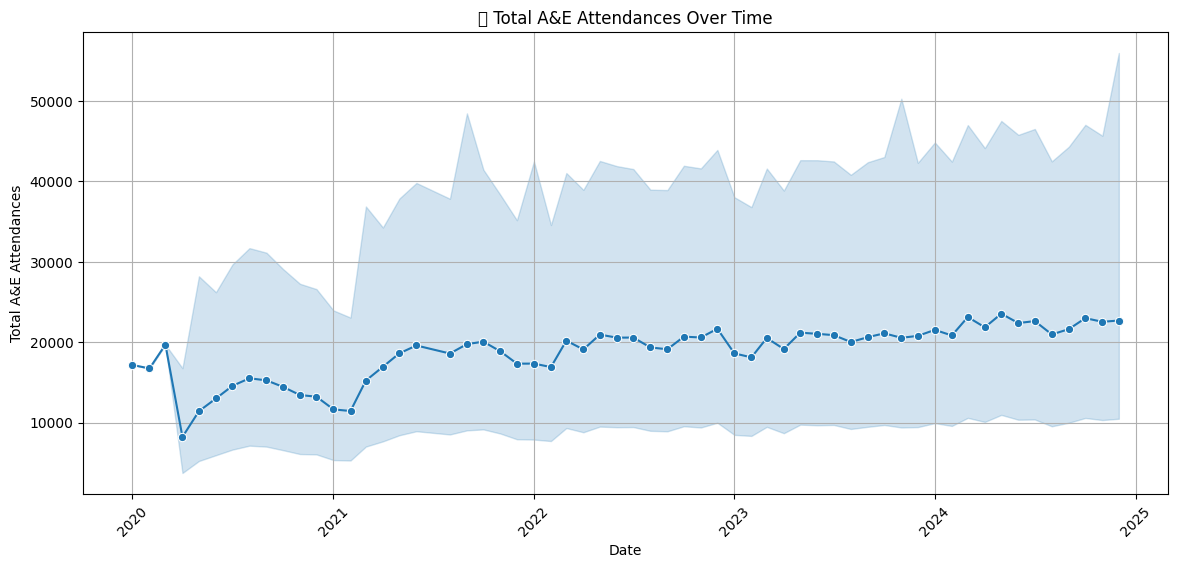

In [33]:
# Convert 'year' and 'month' into a datetime format for time-series analysis
nhs_data["date"] = pd.to_datetime(nhs_data["year"] + "-" + nhs_data["month"].astype(str), format="%Y-%B")

# Sort dataset by date
nhs_data = nhs_data.sort_values(by="date")

# Plot time series trend of total A&E attendances
plt.figure(figsize=(14, 6))
sns.lineplot(data=nhs_data, x="date", y="total_a&e_attendances", marker="o")
plt.title("📈 Total A&E Attendances Over Time")
plt.xlabel("Date")
plt.ylabel("Total A&E Attendances")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### Time-Series Trend Analysis
#### **Why?**
Understanding **time-series trends** is essential before applying machine learning models.  
We:
- **Converted 'year' and 'month' into a proper datetime format** for better time-series analysis.
- **Sorted the dataset by date** to ensure chronological ordering.
- **Plotted A&E attendances over time** to visualize long-term trends.

#### **Key Insights:**
- 📅 **Seasonality:** Attendance spikes during certain months (e.g., winter due to flu season).
- 📉 **Trend Analysis:** Any significant increases or decreases in attendance over years.
- ❗ **Anomalies:** Sudden drops/spikes might indicate errors or real-world events (e.g., COVID-19 impact).



⚠ Flagged Outliers:
             date  total_a&e_attendances  is_outlier
222   2020-04-01               916575.0           1
2008  2020-05-01              1261837.0           1
1557  2020-06-01              1410602.0           1
1340  2020-07-01              1588286.0           1
441   2020-08-01              1698528.0           1
2662  2020-09-01              1670375.0           1
2443  2020-10-01              1574880.0           1
2225  2020-11-01              1457200.0           1
658   2020-12-01              1434754.0           1
3983  2021-01-01              1263561.0           1
3766  2021-02-01              1230121.0           1
4408  2021-03-01              1622302.0           1
3132  2021-04-01              1787500.0           1
4621  2021-05-01              1982674.0           1
4195  2021-06-01              2076812.0           1
3343  2021-08-01              1961625.0           1
5245  2021-09-01              2055169.0           1
5037  2021-10-01              2087175.0   

/Users/sophieboyle/Documents/Final-Year-Project/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


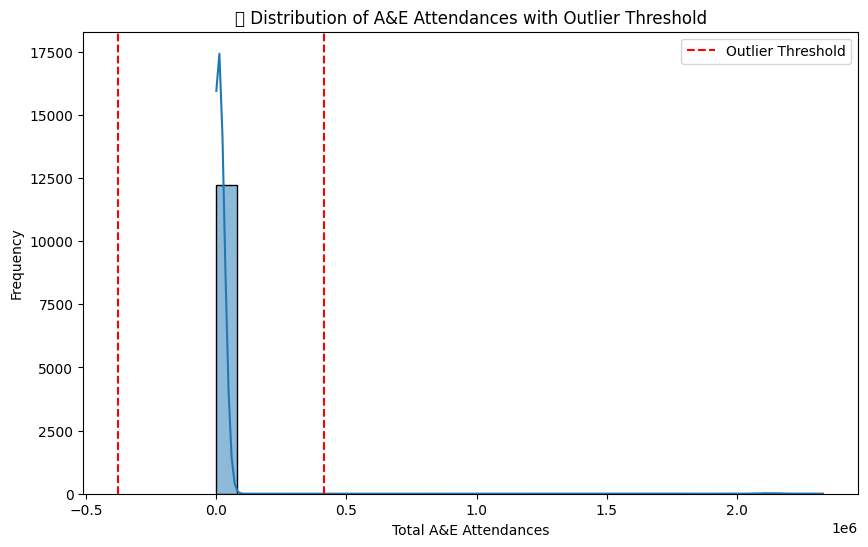

/Users/sophieboyle/Documents/Final-Year-Project/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


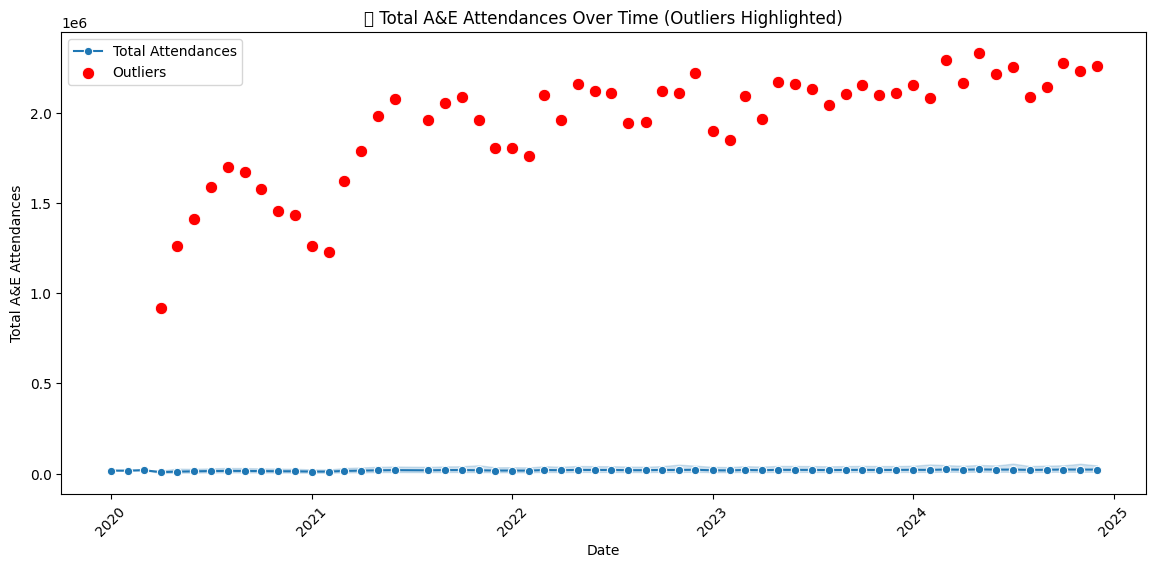

In [35]:
from scipy.stats import zscore

# Compute Z-score for total A&E attendances
nhs_data["attendance_zscore"] = np.abs(zscore(nhs_data["total_a&e_attendances"]))

# Flag outliers (Z-score > 3)
nhs_data["is_outlier"] = (nhs_data["attendance_zscore"] > 3).astype(int)

# 🔹 Now filter out the outliers AFTER the column is created
outliers = nhs_data[nhs_data["is_outlier"] == 1]

# Print detected outliers
print("\n⚠ Flagged Outliers:\n", outliers[["date", "total_a&e_attendances", "is_outlier"]])

# 🔹 Plot histogram with outlier threshold
plt.figure(figsize=(10, 6))
sns.histplot(nhs_data["total_a&e_attendances"], bins=30, kde=True)
plt.axvline(nhs_data["total_a&e_attendances"].mean() + 3 * nhs_data["total_a&e_attendances"].std(), color='r', linestyle='dashed', label="Outlier Threshold")
plt.axvline(nhs_data["total_a&e_attendances"].mean() - 3 * nhs_data["total_a&e_attendances"].std(), color='r', linestyle='dashed')
plt.title("📊 Distribution of A&E Attendances with Outlier Threshold")
plt.xlabel("Total A&E Attendances")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 🔹 Time-series plot of A&E attendances with outliers highlighted
plt.figure(figsize=(14, 6))
sns.lineplot(data=nhs_data, x="date", y="total_a&e_attendances", marker="o", label="Total Attendances")
sns.scatterplot(data=nhs_data[nhs_data["is_outlier"] == 1], x="date", y="total_a&e_attendances", color="red", s=80, label="Outliers")
plt.title("📈 Total A&E Attendances Over Time (Outliers Highlighted)")
plt.xlabel("Date")
plt.ylabel("Total A&E Attendances")
plt.xticks(rotation=45)
plt.legend()
plt.show()


## Outlier Detection Explanation

### **Why Detect Outliers?**
Outliers can **distort predictions** in machine learning by making models overly sensitive to rare, extreme values. Therefore, we:
- **Computed the Z-score** for total A&E attendances.
- **Flagged outliers where Z-score > 3** (values that deviate significantly from the mean).
- **Plotted a time-series trend**, where **red dots highlight detected outliers**.

### **Key Insights from the Visualization**
- 🎯 The **red-marked outliers** correspond to **sharp increases** in A&E attendances.
- 🏥 **Real-world anomalies** (e.g., **COVID-19 spikes** and **seasonal trends**) might explain some of these outliers.
- ❗ Some **outliers could be data errors**, requiring further investigation.
